# Project 4

Första gången man kör behöver man ta ned några paket:

In [1]:
using Pkg
Pkg.add(["Random", "Plots", "RollingFunctions", "Statistics", "LinearAlgebra", "LaTeXStrings", "PyCall"])

   Resolving package versions...
  No Changes to `F:\julia\environments\v1.11\Project.toml`
  No Changes to `F:\julia\environments\v1.11\Manifest.toml`


Notera att ni verkligen bara behöver köra ovanstående första gången ni tankar hem paketen (för att använda dem senare kör man "using PAKETNAMN").

Resten av alla funktioner och tjafs ligger i main (som mest bara är en lista med saker att inkludera just nu eftersom resten körs i notebooken här).

In [72]:
include("main.jl");

All relevant specificering så när som på mina rewards går att specifiera i en LearningParameter- eller Environment-struktur. I varje LearningParameter ingår en Environment. P.g.a. att Jupyter inte lirar med Julia-dokumentering i VSCode så får jag råprinta dem här, men kör man i terminalen så är det bara att dra "?obj" för att se helpdocs på 'obj', så e.g. "?LearningParameters" ger väldigt basic info om LearningParameters-strukturen. För varje funktion (eh, inte efter helgens crunch) har jag skrivit väldigt basic info om vad den gör.

In [3]:
println("Environment-variabler:")
println("")
println.(fieldnames(Environment));

Environment-variabler:

gridsize
mapping_radius
mapping_reward
re_mapping_penalty
bumping_penalty
environment_type
water_density
underlying_map


LearningParameters är en mycket grötig struktur tyvärr. Några fält kan ni nog gissa vad de gör, men andra är mycket mer mystiska.

In [4]:
println("LearningParameters-variabler:")
println("")
println.(fieldnames(LearningParameters));

LearningParameters-variabler:

environment
discount_factor
epsilon
epsilon_decaying
decay_function
episode_length
episode_number
learning_rate
step_number
feature_type
qhat_type
ignore_orthogonal_directions
balancing_tensor
uses_balanced_features
baseline_learning_rate
baseline_constant
baseline_estimator


Just nu har jag satt rewardsen i en terrängfri värld till att returnera reward = 2*(antalet nyutforskade tiles) - (maximala antalet tiles vi kan utforska i ett steg) = 2*(antalet nyutforskade tiles) - 5 . Eftersom jag har fixerat mappnings-radien till 2 så blir ju 5 det maximala antalet vi skulle kunna utforska i teorin. Detta går flexibelt att ändra i Environment). Reward-funktionen är nog värd att experimentera med.

Varje LearningParameter-fält har ett default-value, så man kan nöja sig med att bara specifiera ett fåtal - alla andra sätts till default.

In [5]:
learning_parameters1 = LearningParameters() #det här ger default, som har funkat OK-ish för Erik.
learning_parameters2 = LearningParameters(epsilon = 0.9, discount_factor = 0.3, feature_type = RadialFeatures()); #det här är nog dåliga parametrar.

En rimligare parameteruppsättning nedan:

In [6]:
learning_parameters = LearningParameters(
    environment = Environment(gridsize = 40),
    discount_factor = 0.95,
    epsilon = 0.05,
    episode_length = 100,
    episode_number = 600,
    learning_rate = 0.001,
    step_number = 2,
    );

Vi kan nu köra $n$-step SARSA genom att ange parametrarna. Funktionen kan ombes spotta ut rewards/states som har dykt upp under en av träningsepisoderna - hade varit naturligt att skapa dataframes för dessa, men här är de arrayer som innehåller arrayer. Som default spottar den bara ut våra $\theta$-parametrar som definierar $\hat{q}$ och våra (discounted) returns i träningsepisoderna. För att kunna reproducera kan vi fixera en seed:

In [7]:
Random.seed!(1)
thetas, discounted_returns, plot_data = n_step_SARSA(plotting = true, param = learning_parameters);

I detta fall har jag kört "RadialFeatures()" som features, där har vi något som liknar det som beskrevs på Overleafen: I princip kollar vi antalet outforskade tiles i 4:a cirklar. För varje cirkel får vi två parametrar vilket ger totalt åtta parametrar, ordnade i fyra par om vektorer av längd två.

In [8]:
thetas

4-element Vector{Vector{Float64}}:
 [21.14026486738599, 17.912497230265007]
 [10.597625407750625, 2.9102696755836437]
 [12.96839846156015, 3.3019370023740566]
 [15.34947352092524, 4.110049363456802]

Returnsen ser stökiga ut eftersom vi bara kollar på en körning och har en slumpfaktor $\epsilon$ med:

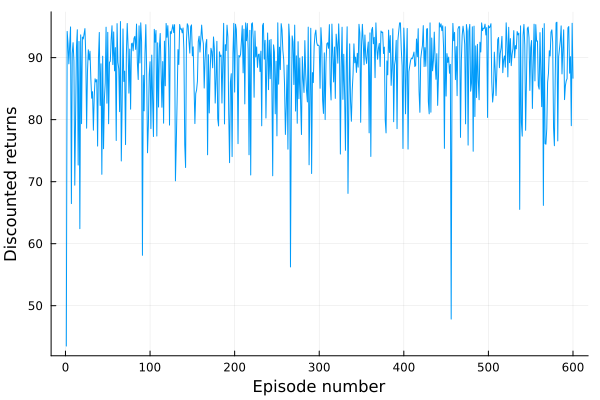

In [9]:
plot(discounted_returns, label = "", xlabel = "Episode number", ylabel = "Discounted returns")

Vad som är värt att notera: Om vi låter agenten tränas i en öppen miljö där den kan röra sig relativt fritt så verkar träningen stabilare. När miljön blir "trång" (många episoder och liten gridworld) så är det fullt möjligt att agenten avlär sig saker.

För att se hur episoden har gått till kan vi köra följande stycke (den sparar automatiskt en gif som heter "Exploradora.gif"). I plot_data som ovan så ligger en vektor med tillstånd (plot_data[1]) och en vektor med rewards (plot_data[2]):

┌ Info: Saved animation to e:\Arbete\Projekt 4 RL\Project-4-RL\Exploradora.gif
└ @ Plots F:\julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("e:\\Arbete\\Projekt 4 RL\\Project-4-RL\\Exploradora.gif")
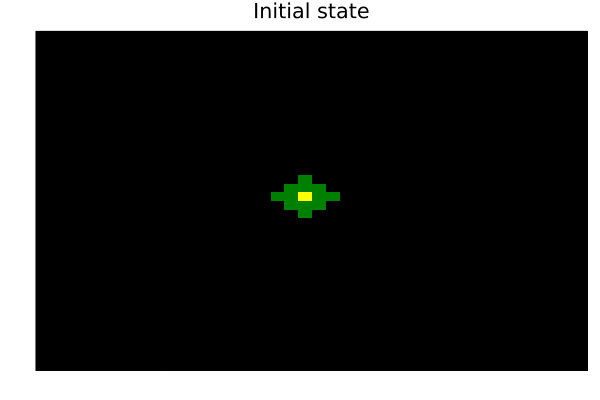

In [10]:
create_animation(plot_data[1],plot_data[2])

Om vi vill få en mer balanserad och rimlig bild av hur vår agent lär sig kan vi istället be den köra episoden ett visst antal gånger och dra genomsnitt på returns samt deras standardfel för att se spridningen i dessa genomsnitt. Eftersom vi egentligen mest är ute efter att se när inlärningen "planar ut" kan vi ta rullande genomsnitt på ett litet antal episoder för att få en mer begriplig bild. I koden nedan kör vi 50 körningar av $n$-step SARSA med parameterarna vi angav ovan och tar rullande genomsnitt på 10 episoder. För tydlighet printas flera parametrar. 

_**Notera att detta kan vara mycket långsamt om man är oförsiktig med input/parametrar - börja med ett par körningar innan du sätter runs till 5000!**_ På min brödrost tar det ungefär 2 sek per körning med ovanstående parametrar, vilket ger lite mindre än 2 minuter i körtid för nedanstående kod. For reference: Koden nedan motsvarar alltså att 50 gånger köra 4-stegs SARSA med 600 episoder med 100 i längd, så totalt 3 milj. steg.

RL-scheme: n_step_SARSA
Number of runs: 50
Rolling average over: 10 episodes
Environment gridsize: 40
Environment mapping radius: 2
Discount factor (gamma): 0.95
Epsilon: 0.05
Epsilon is decaying: false
Episode max. length: 100
Episode number: 600
Learning rate: 0.001
Step number in n-step SARSA: 2
Feature type (see code or ask Erik for definition): RadialFeatures


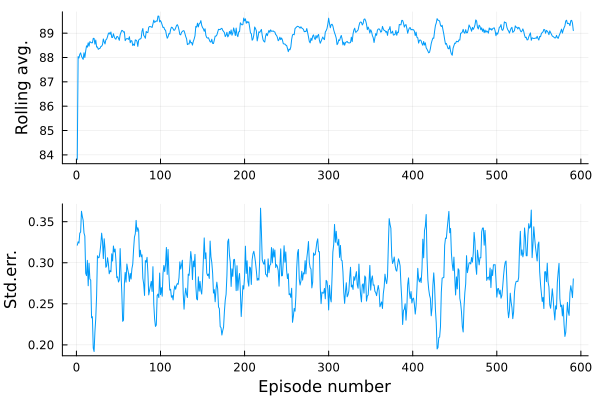

In [11]:
plotrun(n_step_SARSA, learning_parameters, rollnumber = 10, runs = 50)

Här ser det fortfarande lite "jittery" ut, så antagligen skulle vi kunna köra med högre rollnumber för att få en tydligare graf. Samtidigt tappar man ju lite info så det är en avvägning, men i detta fall kanske $rollnumber = 50$ inte vore orimligt. Tyvärr har jag inte byggt funktionen så att man sparar sina runs (nästa steg kanske...) så vill man uppdatera detta får man göra alla beräkningar och träning *igen*. Väldigt dumt.

## Parametrar att leka med:

### Environments

I environment-strukturen har vi lite olika parametrar, låt oss slänga ett öga på dem:

*  _gridsize_ är självförklarande. Storleken på vår värld. Rimliga världen är 20-100 under inlärning, men utanför inlärningsepisoder så spelar detta mindre roll.
*  _mapping\_radius_ är alltså radien av vad agenten kan se. Har bara kört detta värde = 2, så kan finnas buggar om ni testar andra.
*  _mapping\_reward_ anger hur mycket vi belönar agenten för att se nya tiles.
*  _re\_mapping\_penalty_ avgör hur mycket vi penaliserar agenten för att "återse" gamla tiles.
*  _bumping\_penalty_ avgör hur hårt vi straffar agenten för att gå in i "vatten" specifikt (så faktum är att detta just nu inte räknas in om agenten går in i "världens kant")
*  _environment\_type_ är ett symbol-värde, som sätts antingen till ':open' eller ':waterworld'. Annan input kommer skapa kaos, och vara utan mening. Detta avgör om vi genererar terräng eller ej.
*  _water\_density_ är ett tal som anger hur mycket vatten som ska skapas i världen. Det är inte den faktiska densiteten för Eriks enkla kartgenerator utan egentligen närmre ett väntevärde för kartornas riktiga vattendensitet.
*  _underlying\_map_ är den verkliga kartan, som agenten bara ser en del av. Den reppas som en Iny8-matris, där 1 = land, 2 = vatten

Alla dessa har default-värden, underlying map genereras slumpartat i waterworld med Eriks kartgenerator och baserat på de andra värdena som anges. Men, om ni vill kan ni sätta dem själva. Om ni definierar kartan så måste den såklart vara $gridsize \times gridsize$, och om kartan sätts utan att man sätter environment\_type samtidigt till rätt så går allt åt helvete. 

Så te.x. skulle ni kunna säga:

In [12]:
env = Environment(gridsize = 15, environment_type = :waterworld);

och då sätts allt annat. För att se vilka värden är det bara att kolla fälten, e.g.

In [13]:
env.mapping_radius

2

och kartan i sin faktiska form ser jävlig ut:

In [14]:
env.underlying_map

15×15 Matrix{Int8}:
 1  1  1  1  2  1  2  1  1  1  1  1  2  1  1
 1  1  2  1  1  1  1  1  1  1  2  1  1  2  1
 1  1  1  1  1  1  1  1  2  2  2  1  1  1  1
 1  2  1  2  1  1  1  1  1  1  1  2  1  1  2
 2  1  1  1  1  1  1  1  1  1  1  1  2  1  1
 2  1  1  1  1  2  1  1  1  1  1  1  1  2  1
 1  1  1  1  1  1  1  1  1  1  1  1  2  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  2  2  2
 1  1  1  1  1  1  2  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 2  2  1  1  1  1  1  1  1  1  1  1  2  2  1
 2  1  1  2  1  1  2  2  2  1  2  1  2  1  1
 2  1  1  1  2  1  2  1  1  1  1  1  1  2  1
 2  1  1  1  1  1  2  1  1  1  2  2  2  2  2
 2  2  1  1  1  1  1  1  1  2  2  2  2  2  2

Det är bara att experimentera med olika världen här, även om det inte är så intressant i sig kanske. Givet antalet nyutforskade tiles har jag definierat rewardsen på följande sätt:

```julia
if bumped #gick in i vatten!
    return environment.bumping_penalty + environment.re_mapping_penalty * (2*environment.mapping_radius + 1)
end
return new_tile_counter*environment.mapping_reward + environment.re_mapping_penalty * (2*environment.mapping_radius + 1 - new_tile_counter)
```

### LearningParameters

LearningParameters är en catch-all: stökig och ful, men flera parametrar är enkla att vara med på vad de gör


*  _environment_ är ett Environment som vi jobbar i.
*  _epsilon_ säger sig självt.
*  _epsilon_decaying_ är en bool som anger om man i inlärning ska låta $\epsilon$ förfalla mot 0. Hur exakt detta sker definieras av en annan funktion.
*  _decay_function_ är en funktionen som defaultar till att vara på formen $(\epsilon,n) \to \epsilon(0.99)^n$.
*  _episode_length_ är ett heltal som säger hur lång en episod får vara som mest under träning.
*  _episode_number_ är ett heltal som anger hur många episoder som ska köras i en tränings-session.
*  _learning_rate_ är exakt vad man väntar sig.
*  _step_number_ är $n$:et i $n$-step SARSA.
*  _feature_type_ är mystisk, jag tror vi ska lägga en stund att prata om vad jag har skapat för features när jag jobbade med waterworld.
*  Resterande features gör _nästan_ inget vettigt alls, några gör absolut inget just nu eftersom jag inte har implementerat REINFORCE med baseline.

Alla dessa får default-värden men t.ex. 2-stegs SARSA konvergerar nästan direkt (inom ca 200 epsioder) om man kör av längd 40-80 i en gridworld av gridsize 50, så i vissa lägen är defaulten högt ställd. REINFORCE konvergerar ju långsammare p.g.a. Monte-Carlo och beter sig idiotiskt i början, så där är det bättre att ha kortare episoder men flera för träning.

Vill ni testa olika så sätt dem till små värden först.  Körningar i waterworld tar tid. Här är några som jag skulle kunna tänka mig vore bra:

In [15]:
env = Environment(gridsize = 61, environment_type = :waterworld, water_density = 0.17);
lps_sarsa = LearningParameters(environment = env, step_number = 4, episode_length = 80, episode_number = 600)
lps_reinforce = LearningParameters(environment = env, episode_length = 20, episode_number = 2400);

### Att köra inlärning - en träningssession

Det finns två stora metoder implementerade: REINFORCE och n_step_SARSA, och båda är strukturellt lika in input och output.

Som input kan vi mata in tre saker genom att sätta värden på "keywords": 

*  _param_ accepterar en LearningParameters-strukture, e.g. 'param = lps_sarsa'. Default är default LearningParameters.
*  _plotting_ är en bool som, om den sätts till true ser till att samla states och rewards för varje träningsepisod så att episoden kan visualiseras, så e.g. 'plotting = true'. Default är false.
*  _thetas_ är en samling parametrar - faktiskt exakt de som vi tränar upp. Om vi vill starta en ny träningssession utifrån parametrar vi sett förut (mer om det nedan) så kan vi köra in dem här. Default är 'nothing'.

Vad händer i en körning? Jo vi genererar en ny karta (så att agenten inte bara lär sig en karta, utan lär sig miljön) och låter agenten utforska från början igen.

Låt oss köra lite:

In [16]:
tr_sarsa = n_step_SARSA(param = lps_sarsa, plotting = true);

Eftersom vi valde att plotta kommer tr_sarsa innehålla tre saker:

*  Parametrarna som vi har "lärt oss".
*  Returnsen för varje träningsepisod.
*  En tupel av formen (S, R) där S och R är vektorer sådana att S_j och R_j är återigen vektorer av de states och rewards som agenten "stötte" på under j:te träningen.

Den första *går* att förstå, men kräver lite förklaring av hur featuresen har justerats. Innan vi går in på det kan vi plotta vår SARSA-körning:

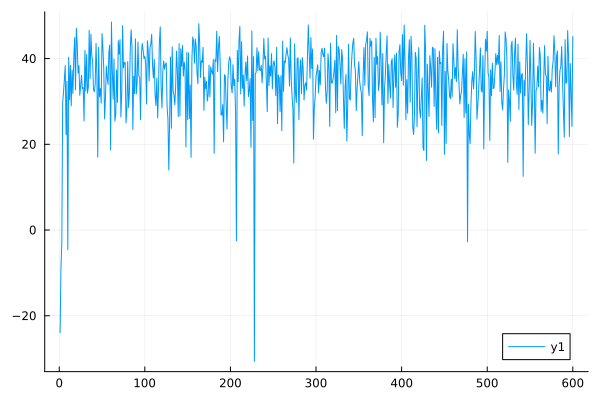

In [17]:
plot(tr_sarsa[2])

Det ser knappt ens ut som inlärning för att det går så fort! Låt oss gå vidare hur man kan återanvända den första delen av outputen igen för att träna mer: Om vi stoppar in den som thetas i funktions-anropet så tränar den vidare utifrån dettas:

In [18]:
tr_sarsa = n_step_SARSA(param = lps_sarsa, plotting = true, thetas = tr_sarsa[1]);

Det där var egentligen helt onödigt, för nu slängde vi alla plots och returns från första träningsperioden men tränade vidare. Nästan garanterat har den inte lärt sig mer, konvergens sker som sagt snabbt. Vi kan plotta returns istället:

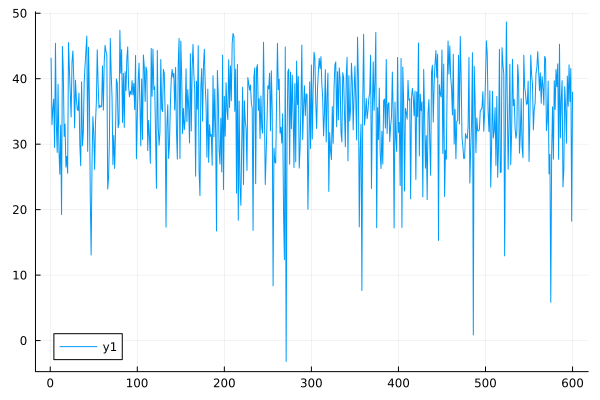

In [19]:
plot(tr_sarsa[2])

Bli inte alltför överraskade om returnsen ser ut som skit ibland - vår agent avskyr vatten och kommer ibland att fastna i ren skräck. Något att tweaka lite kanske.. 

För att animera en episod kan ni anropa följande:

┌ Info: Saved animation to e:\Arbete\Projekt 4 RL\Project-4-RL\Exploradora.gif
└ @ Plots F:\julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("e:\\Arbete\\Projekt 4 RL\\Project-4-RL\\Exploradora.gif")
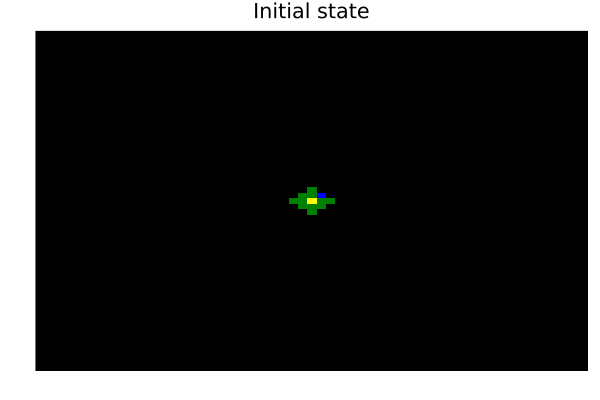

In [20]:
create_animation(tr_sarsa)

Vi har dock sparat alla episoder som kördes ovan så vill man se en specifik så har jag gjort så att man får ange hur långt bak från slutet den ligger (detta är idiotiskt, jag vet men pallar inte fixa). Vi kan också spara med ett annat namn (default "Exploradora.gif"):

┌ Info: Saved animation to e:\Arbete\Projekt 4 RL\Project-4-RL\blursed.gif
└ @ Plots F:\julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("e:\\Arbete\\Projekt 4 RL\\Project-4-RL\\blursed.gif")
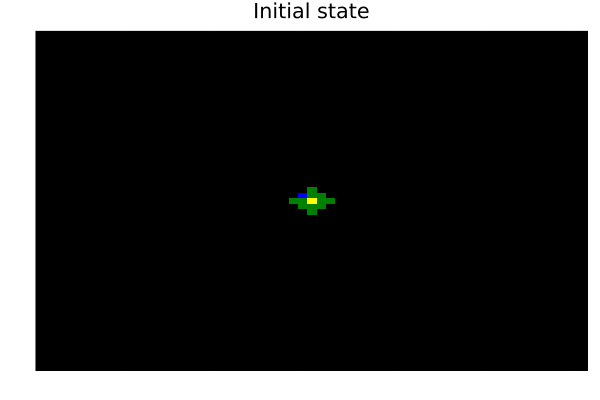

In [21]:
create_animation(tr_sarsa, steps_from_end = 20, name = "blursed")

Vill ni plotta ett specifikt state så går det att göra också. Vi kan t.ex. kolla på ett av statesen i föregående träningssession, även om det ser grötigt ut p.g.a. dum implementering av mig:

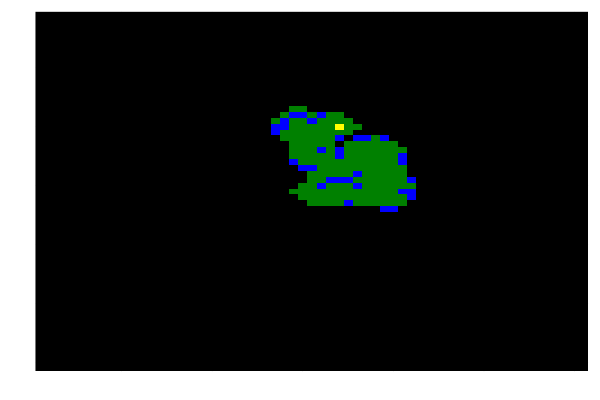

In [22]:
state = tr_sarsa[3][1][600][45] #3:e elementet i tr_sarsa är (S,R) - stateset och rewardset, S[600] är statespacet som agenten upplevde, S[600][45] är 45:e statet den upplevde då.
plotstate(state)

Bara "för att" så kan vi köra REINFORCE också då:

In [23]:
tr_reinforce = REINFORCE(param = lps_reinforce);

REINFORCE är ofta lite segare och lär sig sämre, men mer flexibel som policy so there's that. Eftersom vi inte satte "plotting = true" så får vi ingen "tredje output" utan vara returns och parametrarna. Jag plottar de första 1000-episoderna:

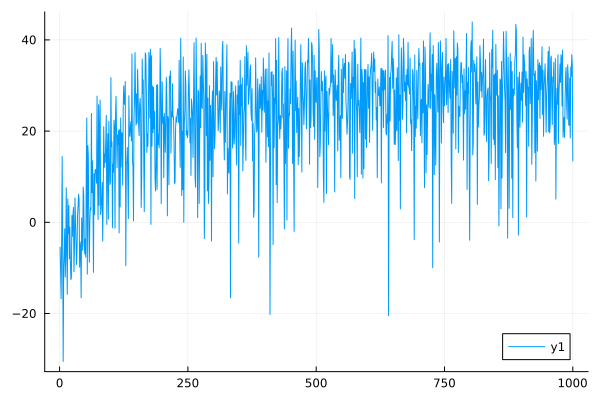

In [24]:
plot(tr_reinforce[2][1:1000])

### Plotrun - ett statistiskt underlag för vår träning.

Utifrån vad vi såg ovan (hoppas jag) verkar REINFORCE konvergera inom 400 episoder ish, och SARSA inom kanske 50? Så vi kan ta samma LearningParameters igen fast med lite justeringar för att ta ett lagom stort träningspass:

In [25]:
lps_sarsa_tuned = LearningParameters(environment = env, step_number = 4, episode_length = 80, episode_number = 100)
lps_reinforce_tuned = LearningParameters(environment = env, episode_length = 20, episode_number = 500);

Nu har vi alltså otroligt mycket mindre träning att göra - så vi kan loopa över träningssessionerna för att ta genomsnitt och varians så att vi ser hur träningen varierar. Plotrun funkar på samma sätt som i mitt första exempel alldeles i början. Ju fler runs vi kör desto tydligare blir mönstrena i träningen. Vi kan ta rullande genomsnitt som iaf inte bör vara större än några procent av episod-antalet, så 5 för SARSA och 25 för REINFORCE med ovanstående episodeantal verkar OK. Om vi är osäkra sätter vi detta tal till 1 och får grötigare (men informationstätare) grafer.

Nedanstående kod tar mig ca 22 sek för SARSA och 1min för REINFORCE:

RL-scheme: n_step_SARSA
Number of runs: 20
Rolling average over: 5 episodes
Environment gridsize: 61
Environment mapping radius: 2
Discount factor (gamma): 0.9
Epsilon: 0.1
Epsilon is decaying: false
Episode max. length: 80
Episode number: 100
Learning rate: 0.001
Step number in n-step SARSA: 4
Feature type (see code or ask Erik for definition): WWRadialFeatures


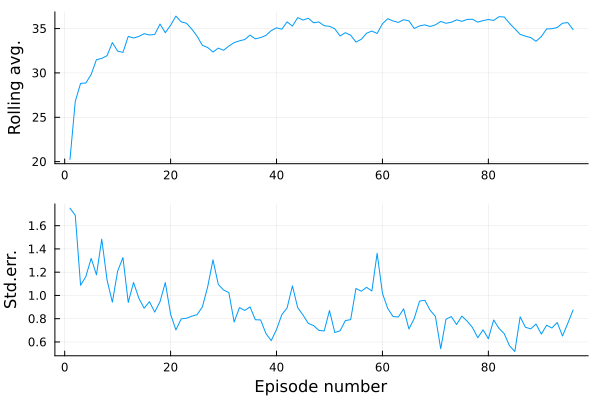

In [26]:
plot_sarsa = plotrun(n_step_SARSA, lps_sarsa_tuned, runs = 20, rollnumber = 5)

RL-scheme: REINFORCE
Number of runs: 20
Rolling average over: 25 episodes
Environment gridsize: 61
Environment mapping radius: 2
Discount factor (gamma): 0.9
Epsilon: 0.1
Epsilon is decaying: false
Episode max. length: 20
Episode number: 500
Learning rate: 0.001
Feature type (see code or ask Erik for definition): WWRadialFeatures


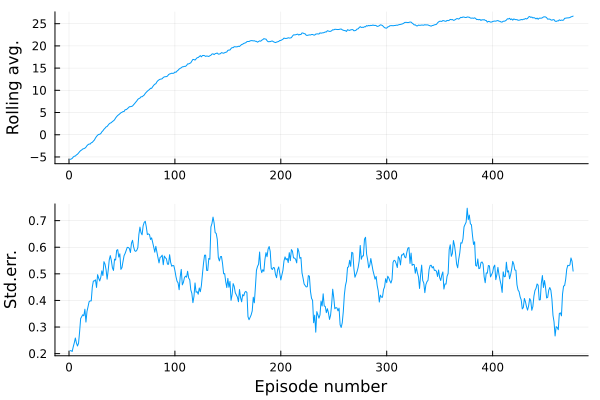

In [27]:
plot_reinforce = plotrun(REINFORCE, lps_reinforce_tuned, runs = 20, rollnumber = 25)

Just nu kan man inte samköra dessa plots, jag fixar detta tills onsdag. Men REINFORCE är ju konsekvent sämre här och exakt vad det beror på är svårt att säga. Kan vi räkna ut det vore det en bra talking point. Går att analysera genoma att visualisera många körningar.

### Att testa ett scenario

Antag att ni vill testa agenten efter träning i en viss miljö (definierad av en matris M som anger kartan). Ni behöver då parametrarna som agenten lärt sig. Låt oss ta dem vi fick i SARSA-träningen ovan:

In [28]:
thetas = tr_sarsa[1];

Tyvärr var jag "lat" när jag skrev koden så detta räcker inte för att en agent ska veta vad den ska göra. Den behöver veta sin "feature_type" också. Den står med i LearningParameters, så vi ska alltså använda samma som vi använde när vi tog fram tr_sarsa[1] i detta fall. (Det gör inget om det environment som den tränades i inte matchar det den ska agera i nu, så ert scenario kan ha en större gridworld eller gridworld av annorlunda vattendensitet - det spelar ingen roll om inga buggar har dykt upp). Alltså ska vi mata in i detta fall

In [29]:
lps_sarsa;

Just nu kan agenten bara börja mitt i kartan men vi kan alltså släppa lös vår tränade agent. Definiera en egen karta eller generera en med Augusts eller Eriks kod (notera att det är en liten skillnad i hur vi har definierat dem, för att det ska funka ska vi ha land = 1, vatten = 2). Kartan kan inte vara större än 127 enheter p.g.a att jag har tvingat Int8.

Det går också att låta agenten se några tiles från början i explored - en matris där man skriver 1:or på de tiles agenten ska se, och 0:or annars.

Slutligen måste ni bestämma policy-typ explicit (för att spara mig lite lidande har jag inte skrivit kod för att lösa detta). Detta kan vara antingen :greedy, :epsgreedy eller :softmax. Notera att om ni tränar REINFORCE får ni såklart bara köra :softmax och tvärt om.

In [113]:
gridsize = 81
underlying_map = map_generator(gridsize, :waterworld, density = 0.99) #genererar en karta från Eriks set
pol_type = :greedy #kunde alltså ha varit :epsgreedy eller :softmax
maxl = 100 #maximal episode length
expl_tiles = create_random_bool_matrix(gridsize, 0.05);

Nu är det bara att "mata in":

In [114]:
scenario1 = run_scenario(thetas, lps_sarsa, underlying_map, pol_type, max_length = maxl, explored = expl_tiles);

run_scenario returnernar tre vektorer i en tupel - vektorn av states, vektorn av rewards, och vektorn av actions. Så vi kan t.ex. kolla på den 25:e statet

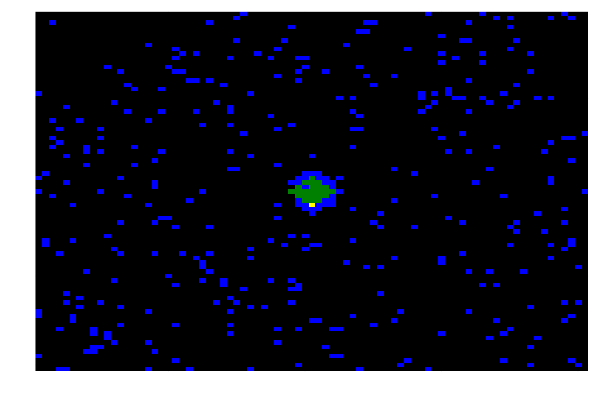

In [115]:
plotstate(scenario1[1][25])

För att animera kan vi använda följande (notera att kartan kan bugga ur om man inte är försiktig med ursprungstillståndet - färgschemat kan fucka ur):

┌ Info: Saved animation to e:\Arbete\Projekt 4 RL\Project-4-RL\scenario.gif
└ @ Plots F:\julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("e:\\Arbete\\Projekt 4 RL\\Project-4-RL\\scenario.gif")
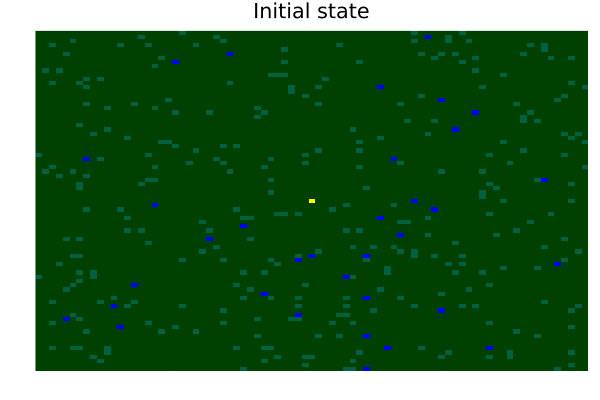

In [34]:
create_animation_scenario(scenario1)

Ni kan också räkna returns för scenariot med det gamma som sattes i LearningParameters eller manuellt:

In [35]:
returns_scenario(scenario1, lps_sarsa.discount_factor)

46.18574368277011

In [36]:
returns_scenario(scenario1, 0.9999999999)

401.9999980841999

### Olika features & approximationer

I LearningParameters har vi en feature_type som är en sorts struktur. För waterworld så är dessa lite intressanta iaf. Det finns bara en feature_type jag har implementerat för waterworld, nämligen WWRadialFeatures. I grund och botten är de _väldigt_ lika de vi har diskuterat tidigare - men de räknar antalet tiles av "varje sort" (outforskade, vatten, land, outofbounds). 

In [47]:
basic_feature_type = WWRadialFeatures()

WWRadialFeatures(true, Int8[1, 2])

Detta är återigen en struktur som vi har två fält i:

*  _basic\_features.include\_the\_horizon_ är en bool som anger om vi ska ta med features som motsvarar det vi tidigare kallade $[N,E,S,W]$ för vatten och outforksade tiles - alltså ska vi kolla i varje riktning och räkna antalet tiles. För varje typ av tile får man då en vektor $[N,E,S,W]$ som säger hur mycket vi ser av varje tile (och i proportion till kartans storlek). Default är att detta är true.
*  _radius\_vector_ är en lista av olika radier på vilka vi vill kolla på kartan och räkna tiles på exakt denna radie i varje riktning. Den defaultar till att kolla två radier, men man kan själv variera. För varje radie _och typ av tile_ får man en vektor $[N,E,S,W]$ som anger hur många tiles som finns på denna radie i den givna riktningen. Detta är mycket data att släpa runt, så det blir lite långsamt.

Låt oss testa för något tillstånd från ovan.

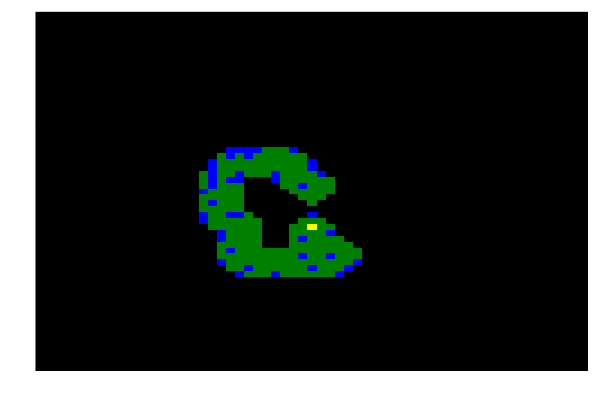

In [42]:
state_from_tr_sarsa = tr_sarsa[3][1][100][56]
plotstate(state_from_tr_sarsa)

In [50]:
feats = features_water_world(state_from_tr_sarsa, lps_sarsa.environment, basic_feature_type)

WaterworldFeatures([0.5, 0.0, 0.0, 0.0], [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]], [[1.1131416285944638, 0.9610319806503628, 0.7293738242407954, 0.8857833915614082], [1.0, 0.6, 0.0, 0.6], [0.8571428571428571, 0.7142857142857143, 0.2857142857142857, 0.7142857142857143]], [[0.015049717817790917, 0.0032249395323837677, 0.00806234883095942, 0.017737167428110722], [0.0, 0.2, 0.4, 0.2], [0.0, 0.0, 0.0, 0.0]])

Ut trillar features i strukturen WaterworldFeats, som har fyra fält. 

*  _water\_blocking_ kollar om det är vatten ivägen i någon kardinalriktning inom mappningsradien. Alltså om agenten går i denna riktning och detta värde inte är noll så kommer agenten gå in i "vatten". Detta är en vektor.
*  _beyond_ är en lite dum feature som för varje radie kollar antalet tiles som är "utanför världen" i radien. Denna hade inte behövt kollas på detta sätt. Det blir en vektor för varje radie.
*  _water_ kollar för varje radie antalet tiles som är vatten i radien. En vektor för varje radie + 1 om vi kör include_horizon
*  _unmapped_ kollar för varje radie antalet tiles som är vatten i radien. En vektor för varje radie + 1 om vi kör include_horizon


Från dessa har jag gjort samma linjära approximation som vi hade diskukterat tidigare för $\hat{q}(\bold{x}, a, \bold{w})$ och som också är rimlig för soft-max-exponenenten $h(\bold{x}, a, \bold{w})$. Dock så har water_blocking-featen (kalla den $\bold{b}$) fått ett eget beteende eftersom det är en annan typ av feature än de andra. Så e.g. för $h$:

$h(\bold{x}, a, \bold{w}) = w_0 \bold{b}_{a} + \bold{w}^T B(a) \bold{x} = w_0 \bold{b}_{a} + \sum_{j\geq 1} \bold{w}_j^T A(a) \bold{x}_j$

där $\bold{x}_j$ motsvarar en vektor av features ur feats, och $\bold{w}_j$ är en motsvarande parameter. Dessa lagras just nu som state-action features istället, alltså som $A(a)\bold{x}_j$ vilket skapar färre uträkningar men äter upp mycket mer minne. Vad som är effektivast beror på dator - om koden verkar långsammare nu, även i basic-implementeringen av vanlig gridworld så är det p.g.a. detta.

### Experiment med features:

Ni kan testa att låta feature_type:n variera.

In [58]:
big_feats = WWRadialFeatures(radius_vector = [1,2,7]) #kommer nu kolla alla tiles som är 1, 2 eller 7 radier utifrån kanten av vad agenten ser.
lps_sarsa_many_radii = LearningParameters(environment = env, step_number = 4, episode_length = 80, episode_number = 600, feature_type = big_feats)

LearningParameters(Environment(61, 2, 1.0, -1.0, -2.0, :waterworld, 0.17, Int8[2 2 … 1 1; 1 1 … 2 1; … ; 1 1 … 2 1; 1 2 … 1 1]), 0.9, 0.1, false, var"#61#63"(), 80, 600, 0.001, 4, WWRadialFeatures(true, Int8[1, 2, 7]), LinearBalancedQhat(), true, [1.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0;;; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 1.0;;; 0.0 0.0 1.0 0.0; 1.0 0.0 0.0 0.0;;; 0.0 0.0 0.0 1.0; 0.0 1.0 0.0 0.0], true, 0.001, 0.0, :nil)

Låt oss träna med dessa (Ju fler feats/radier desto mer minne går det åt dock)

In [59]:
tr_sarsa_big_feats = n_step_SARSA(param = lps_sarsa_many_radii, plotting = true);

┌ Info: Saved animation to e:\Arbete\Projekt 4 RL\Project-4-RL\Exploradora.gif
└ @ Plots F:\julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("e:\\Arbete\\Projekt 4 RL\\Project-4-RL\\Exploradora.gif")
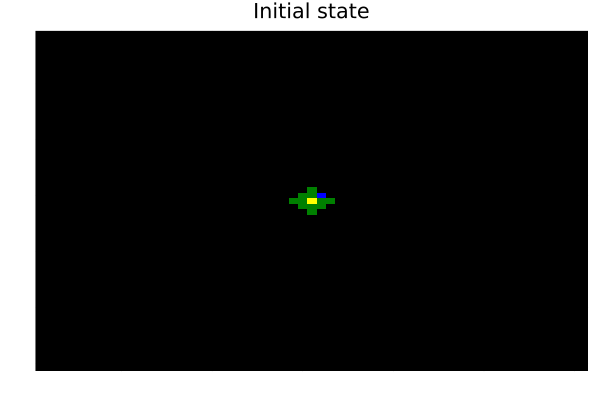

In [61]:
create_animation(tr_sarsa_big_feats)

Det vi har tränat är våra $\bold{w}$ och dessa spottas ut i första entry:t av n_step_SARSA:s output, så det vår agent har lärt sig är

In [ ]:
tr_sarsa_big_feats[1]

WaterworldParameters(-19.444685108628562, [[-1.3168906024492428, -0.9303365140525616], [-2.2475075160508533, -1.3040713008295017], [-5.596847373582595, -2.0293697016628878]], [[0.44652788174656555, 0.513162692635762], [11.416424051600917, 0.9749355226676378], [9.61498784510751, 1.8148673794860952], [7.616747003140547, 2.4649751815200385]], [[-0.2588973181869977, -0.37124978089828337], [-3.6338594450339454, -1.4408861778296242], [-1.4554603222369644, -1.2151708383917392], [-0.5716742008262736, -0.5019581637247024]])

och det är dessa vi skulle mata in i olika scenarion. 

n-step SARSA verkar ju bäst, men för att konvergera mot en rimlig policy bör vi ha ett decaying epsilon. Vi tränar igen

In [63]:
lps_sarsa_decaying = LearningParameters(environment = env, step_number = 4, episode_length = 80, episode_number = 600, epsilon_decaying = true)
tr_sarsa_decaying = n_step_SARSA(param = lps_sarsa_decaying, plotting = true);

Vi kan jämföra med resultaten ovan (där vi hade mer avancerade features istället):

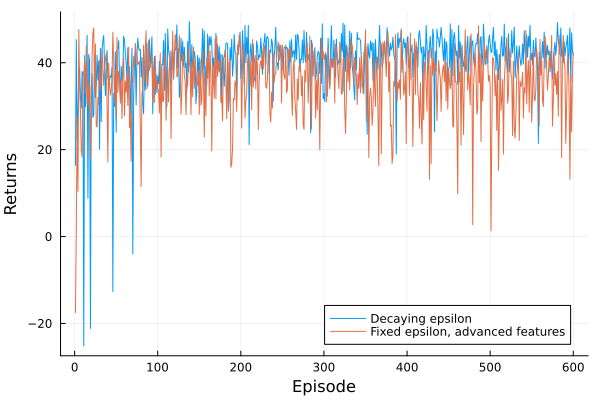

In [67]:
plot(tr_sarsa_decaying[2], label ="Decaying epsilon", ylabel = "Returns", xlabel = "Episode")
plot!(tr_sarsa_big_feats[2], label ="Fixed epsilon, advanced features")

Beroende på seed så varierar resultatet, men detta verkar stabilare än alternativet. Vi bekräftar ju genom 'plotrun':

RL-scheme: n_step_SARSA
Number of runs: 10
Rolling average over: 10 episodes
Environment gridsize: 61
Environment mapping radius: 2
Discount factor (gamma): 0.9
Epsilon: 0.1
Epsilon is decaying: true
Episode max. length: 80
Episode number: 600
Learning rate: 0.001
Step number in n-step SARSA: 4
Feature type (see code or ask Erik for definition): WWRadialFeatures


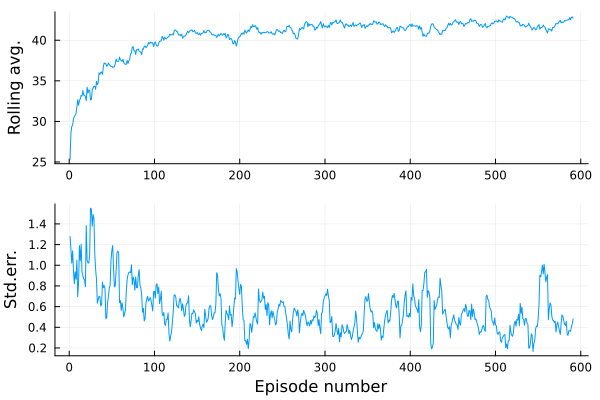

In [68]:
plotrun(n_step_SARSA, lps_sarsa_decaying, runs = 10, rollnumber = 10)

vilket ska jämföras med

RL-scheme: n_step_SARSA
Number of runs: 10
Rolling average over: 10 episodes
Environment gridsize: 61
Environment mapping radius: 2
Discount factor (gamma): 0.9
Epsilon: 0.1
Epsilon is decaying: false
Episode max. length: 80
Episode number: 600
Learning rate: 0.001
Step number in n-step SARSA: 4
Feature type (see code or ask Erik for definition): WWRadialFeatures


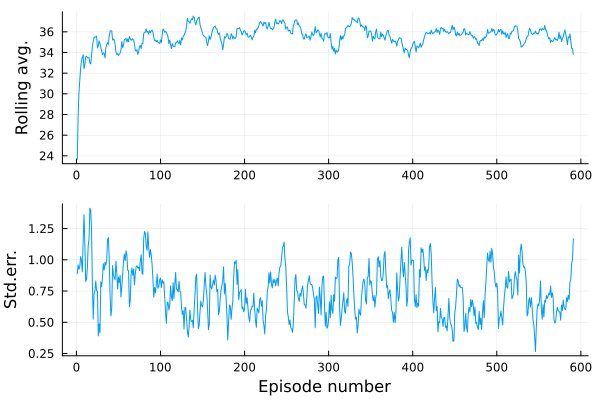

In [70]:
plotrun(n_step_SARSA, lps_sarsa_many_radii, runs = 10, rollnumber = 10)

...och mycket riktigt får vi en bättre asymptotisk policy av att låta $\epsilon \to 0$. Vi kan se värdet på epsilon i 600:e episoden:

In [71]:
eps = lps_sarsa_decaying.epsilon
lps_sarsa_decaying.decay_function(eps,600)

0.0002405009291311067

så det finns en chans på 0.02\% att göra något slumpartat istf. att följa en $\hat{q}$-girig policy i detta steg.

### Det sämsta av det sämsta

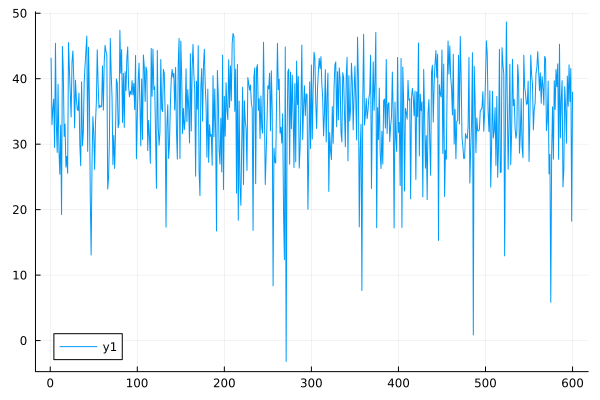

In [78]:
plot(tr_sarsa[2])

Ibland går det fel. Vi kan vilja se vad som går fel - genom att ange en episode i en output i create animation löser vi det:

┌ Info: Saved animation to e:\Arbete\Projekt 4 RL\Project-4-RL\Exploradora.gif
└ @ Plots F:\julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("e:\\Arbete\\Projekt 4 RL\\Project-4-RL\\Exploradora.gif")
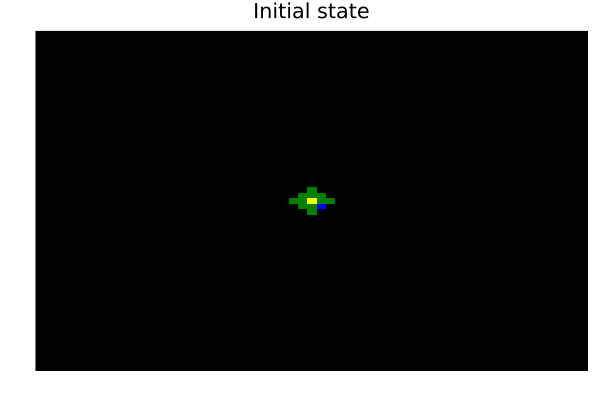

In [76]:
worst = findmin(tr_sarsa[2])
create_animation(tr_sarsa, worst[2])